In [30]:
import torch
import urllib
import numpy as np
from PIL import Image
from torchvision import transforms
import nrrd

In [5]:
# get list of models
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)
# load pretrained models, using ResNeSt-50 as an example
model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)

Downloading: "https://github.com/zhanghang1989/ResNeSt/zipball/master" to /cluster/home/felixzr/.cache/torch/hub/master.zip
Using cache found in /cluster/home/felixzr/.cache/torch/hub/zhanghang1989_ResNeSt_master


In [67]:
def get_image_from_nrrd_z(filename, z):
    # Load the NRRD file
    filename = filename
    data, header = nrrd.read(filename)

    # Extract the image data
    image_data = data.squeeze()[z]  # Assuming the image data is in a single channel, get the z-slice
    
    # Convert the image data to a PIL Image
    # image = Image.fromarray(image_data[z]) 

    # Convert pixel values to float
    img_array_float = image_data.astype(float)

    # Convert back to image
    img_float = Image.fromarray(img_array_float)
    return img_float
    

In [74]:
# input_image = Image.open(filename)
# m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))


filename = "/cluster/work/felixzr/TDT4265_StarterCode_2024/data/ASOCA/Normal/CTCA/Normal_1.nrrd"
z = 150
input_image = get_image_from_nrrd_z(filename, z)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)

if input_tensor.shape[0] == 1:
    # concatenate the tensor along the channel dimension to convert it to an RGB image.
    input_tensor = torch.cat((input_tensor, input_tensor, input_tensor), dim=0)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_tensor = normalize(input_tensor)

input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

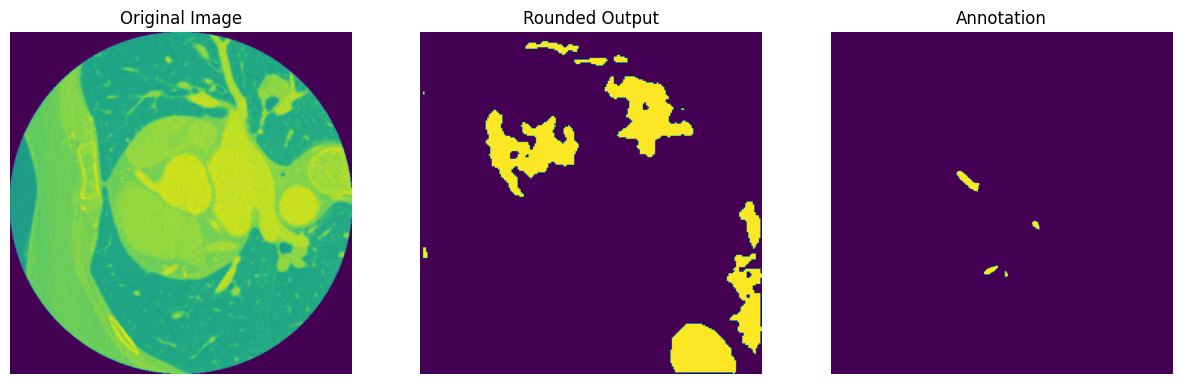

In [82]:
import matplotlib.pyplot as plt
import torch
import nrrd

# Load the NRRD file and extract the desired slice
orig_nrrd_filename = "/cluster/work/felixzr/TDT4265_StarterCode_2024/data/ASOCA/Normal/CTCA/Normal_1.nrrd"
z_slice_index = 150  # Specify the index of the slice you want to extract
data, header = nrrd.read(orig_nrrd_filename)
orig_nrrd_filename = data[:, :, z_slice_index]  # Extract the slice


# Load the NRRD file and extract the desired slice
nrrd_filename = "/cluster/work/felixzr/TDT4265_StarterCode_2024/data/ASOCA/Normal/Annotations/Normal_1.nrrd"
z_slice_index = 150  # Specify the index of the slice you want to extract
data, header = nrrd.read(nrrd_filename)
nrrd_slice = data[:, :, z_slice_index]  # Extract the slice


# Assuming your tensors are named 'image_tensor' and 'image_tensor_round'
image_tensor = output[0].cpu()
image_tensor_round = torch.round(output[0]).cpu()

# Convert tensors to NumPy arrays
image_np = image_tensor.permute(1, 2, 0).numpy()
image_round_np = image_tensor_round.permute(1, 2, 0).numpy()

# Plot the images using subplots
plt.figure(figsize=(15, 5))

# Plot the first image (original image)
plt.subplot(1, 3, 1)
plt.imshow(orig_nrrd_filename)
plt.title('Original Image')
plt.axis('off')

# Plot the second image (rounded output)
plt.subplot(1, 3, 2)
plt.imshow(image_round_np)
plt.title('Rounded Output')
plt.axis('off')

# Plot the third image (NRRD slice)
plt.subplot(1, 3, 3)
plt.imshow(nrrd_slice)  # Assuming the NRRD slice is grayscale
plt.title('Annotation')
plt.axis('off')

plt.show()
